# Generate synthetic wavefields

In [1]:
from obspy.clients.syngine import Client as SyngineClient
from obspy import UTCDateTime
import numpy as np, h5py, math, random
from tqdm import tqdm
import random
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm import tqdm

# Randomly select one regime, generate a source, and visualize wavefields on a sphere
import matplotlib.pyplot as plt

In [2]:
SEED = 20250815
rng = np.random.default_rng(SEED)
random.seed(SEED)

syn = SyngineClient()
ot = UTCDateTime("2010-01-01T00:00:00")  # arbitrary absolute origin time

# spherical grid
N_SENSORS = 1024*2          # try 64, 128, 256 …
COMPONENTS = "Z"       # rows will be S*C = N_SENSORS*3
component_order = list(COMPONENTS)
UNITS = "velocity"       # displacement|velocity|acceleration

# time window (phase-relative to P) - LIMITED TO 1 HOUR FOR SYNGINE
WINDOW_START = ot #"P-30"
WINDOW_END   = ot + 3600 #"P+1200"  # Max 3600s (1 hour) for bulk downloads

# source controls
MW_RANGE   = (5.5, 6.8)
DEPTH_M    = (5000.0, 200000.0)  # 5–200 km
GAUSS_WIDTH_SEC = 8.0            # Gaussian STF width (seconds)
DT_OPTIONAL = 1.0               # up sampling rate (None to use syngine default)


# Earth models

In [3]:
REGIMES = [
    # ak135 & variants 
    dict(name="R1",  model="ak135f_2s",  atten=False), #  no attenuation
    dict(name="R2",  model="ak135f_2s",  atten=True),  #  with attenuation
    # PREM &variants family
    dict(name="R3",  model="prem_i_2s",  atten=False),  # isotropic / no attenuation
    dict(name="R4",  model="prem_a_2s",  atten=False), # anisotropic / no attenuation
    dict(name="R5",  model="prem_e_2s",  atten=False),   # elastic / no attenuation
    dict(name="R6",  model="prem_i_2s",  atten=True),  # isotropic / with attenuation
    dict(name="R7",  model="prem_a_2s",  atten=True), # anisotropic / with attenuation
    dict(name="R8",  model="prem_e_2s",  atten=True),   # elastic / with attenuation
    # IASP91 family 
    dict(name="R9",  model="iasp91_2s",  atten=False), # no attenuation
    dict(name="R10",  model="iasp91_2s",  atten=True),  # with attenuation
    # domain-shift knobs: same model but different source location
]

In [4]:
def mw_to_m0(mw):  # Hanks & Kanamori 1979
    return 10.0 ** (1.5 * mw + 9.1)

def random_normal_thrust():
    """Generate random normal or thrust fault earthquake parameters"""
    # uniform on the sphere for source location
    u = rng.uniform(-1, 1)
    lat = np.degrees(np.arcsin(u))
    lon = rng.uniform(-180, 180)
    depth = rng.uniform(35000.0, 300000.0)  # 35-300 km depth
    mw = rng.uniform(*MW_RANGE)
    m0 = mw_to_m0(mw)
    strike = rng.uniform(0, 360)
    dip = rng.uniform(5, 45)  # Typical dip range for normal/thrust faults
    # Normal faults: rake around -90°, Thrust faults: rake around +90°
    rake = rng.choice([-90, 90]) + rng.uniform(-30, 30)  # ±30° variation
    return dict(lat=lat, lon=lon, depth=depth, mw=mw, m0=m0,
                strike=strike, dip=dip, rake=rake, fault_type="normal_thrust")

def random_strike_slip():
    """Generate random strike-slip earthquake parameters"""
    # uniform on the sphere for source location
    u = rng.uniform(-1, 1)
    lat = np.degrees(np.arcsin(u))
    lon = rng.uniform(-180, 180)
    depth = rng.uniform(5000.0, 20000.0)  # 5-20 km depth
    mw = rng.uniform(*MW_RANGE)
    m0 = mw_to_m0(mw)
    strike = rng.uniform(0, 360)
    dip = rng.uniform(80, 90)  # Nearly vertical
    # Strike-slip: rake around 0° (right-lateral) or 180° (left-lateral)
    rake = rng.choice([0, 180]) + rng.uniform(-20, 20)  # ±20° variation
    return dict(lat=lat, lon=lon, depth=depth, mw=mw, m0=m0,
                strike=strike, dip=dip, rake=rake, fault_type="strike_slip")

def random_dc(i):
    """Generate random double-couple earthquake (backwards compatibility)"""
    # Randomly choose between normal/thrust and strike-slip
    if i < 0.5:
        return random_normal_thrust()
    else:
        return random_strike_slip()
    

def fibonacci_sphere(n):
    # returns list of (lat, lon) approximately uniform on S^2
    # longitudes in [-180,180], lat in [-90,90]
    pts = []
    phi = (1 + 5**0.5) / 2
    for i in range(n):
        z = 1 - 2*(i+0.5)/n
        r = math.sqrt(max(0.0, 1 - z*z))
        theta = 2*math.pi*i/phi
        x, y = r*math.cos(theta), r*math.sin(theta)
        lat = math.degrees(math.asin(z))
        lon = math.degrees(math.atan2(y, x))
        pts.append((lat, lon))
    return pts

Interpolated points for the visualization

In [5]:
# Create a high-resolution spherical grid for interpolation
n_theta = 90  # Number of points in theta (latitude)
n_phi = 180   # Number of points in phi (longitude)

theta = np.linspace(0, np.pi, n_theta)        # 0 to π (colatitude)
phi = np.linspace(0, 2*np.pi, n_phi)          # 0 to 2π (longitude)
theta_grid, phi_grid = np.meshgrid(theta, phi)

# Convert spherical coordinates to Cartesian for interpolation grid
x_grid = np.sin(theta_grid) * np.cos(phi_grid)
y_grid = np.sin(theta_grid) * np.sin(phi_grid)
z_grid = np.cos(theta_grid)

# Flatten for interpolation
x_interp = x_grid.flatten()
y_interp = y_grid.flatten()
z_interp = z_grid.flatten()
interp_points = np.column_stack((x_interp, y_interp, z_interp))

Check that the sensors are well located

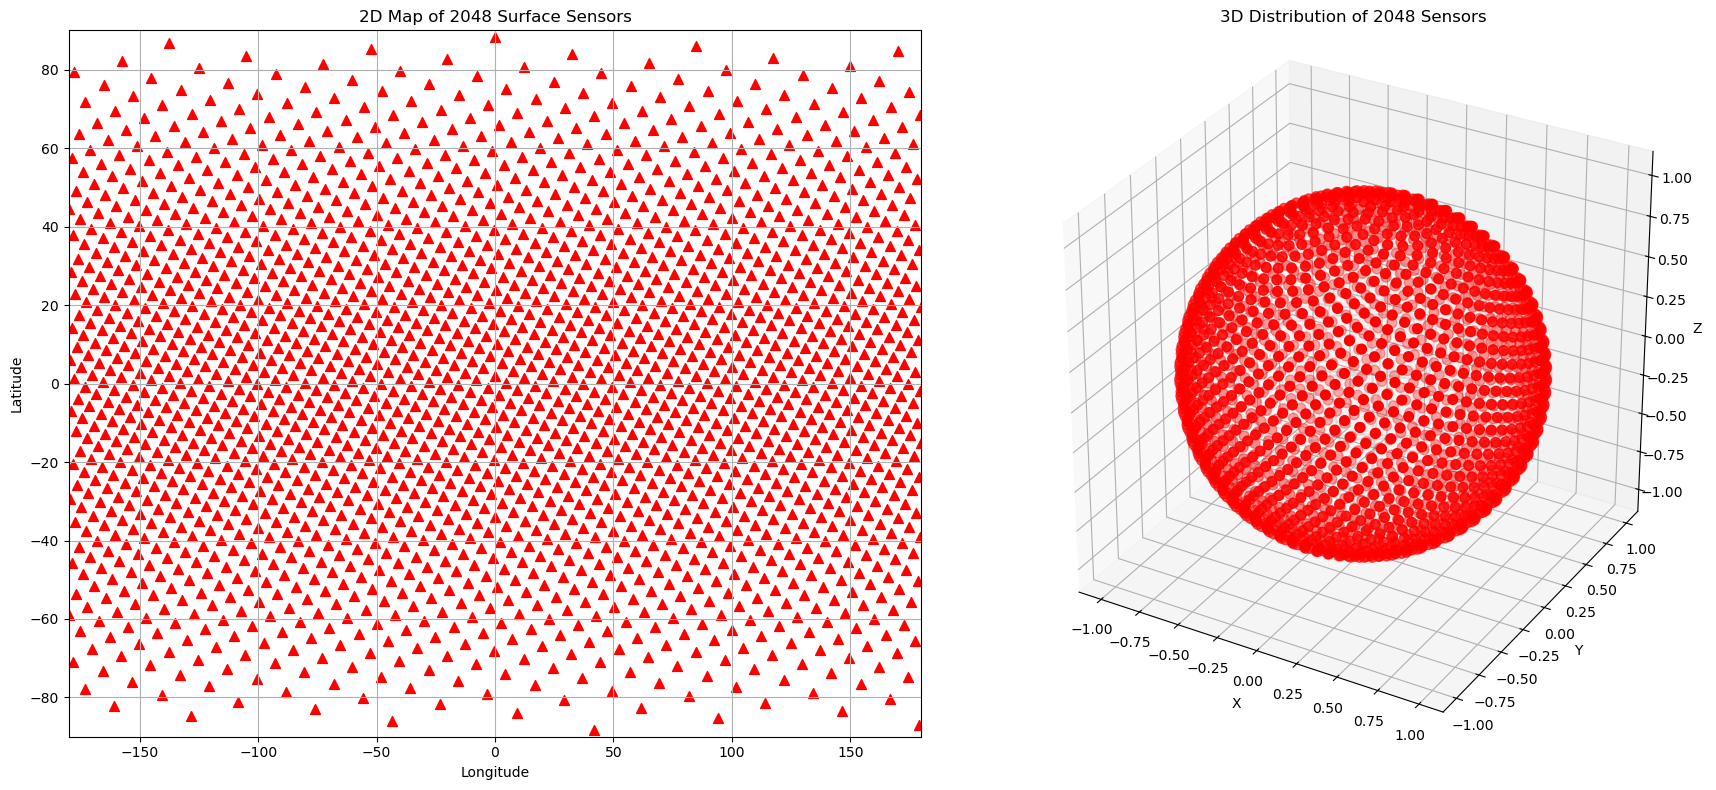

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Generate sensor locations using fibonacci sphere
sensor_locations = fibonacci_sphere(N_SENSORS)
lats, lons = zip(*sensor_locations)

# Create a figure with two subplots
fig = plt.figure(figsize=(18, 8))

# 2D Map View
ax1 = fig.add_subplot(121)
ax1.scatter(lons, lats, color='red', marker='^', s=50)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title(f'2D Map of {N_SENSORS} Surface Sensors')
ax1.set_xlim(-180, 180)
ax1.set_ylim(-90, 90)
ax1.grid(True)

# 3D Sphere View
ax2 = fig.add_subplot(122, projection='3d')

# Convert lat/lon to 3D Cartesian coordinates
x, y, z = [], [], []
for lat, lon in sensor_locations:
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    x.append(np.cos(lat_rad) * np.cos(lon_rad))
    y.append(np.cos(lat_rad) * np.sin(lon_rad))
    z.append(np.sin(lat_rad))

# save sensor coordinates for later use as a pandas data frame with the lat, long, x, y, z
import pandas as pd
sensor_df = pd.DataFrame({
    'latitude': lats,
    'longitude': lons,
    'x': x,
    'y': y,
    'z': z
})
sensor_df.to_csv('sensor_locations.csv', index=False)

# Plot the sensor locations
ax2.scatter(x, y, z, color='red', marker='o', s=50)

# Draw a wireframe sphere for reference
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
sphere_x = np.cos(u) * np.sin(v)
sphere_y = np.sin(u) * np.sin(v)
sphere_z = np.cos(v)
ax2.plot_wireframe(sphere_x, sphere_y, sphere_z, color='gray', alpha=0.2)

ax2.set_title(f'3D Distribution of {N_SENSORS} Sensors')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Try to set equal aspect ratio
try:
    ax2.set_box_aspect([1,1,1])
except AttributeError:
    ax2.set_aspect('equal')
    
plt.tight_layout()
plt.show()

Generate a first data set and visualization

In [7]:

# 1. Randomly select one regime
selected_regime = random.choice(REGIMES)
print(f"Selected regime: {selected_regime['name']} - {selected_regime['model']}")

# 2. Generate a random source
source = random_dc(0.3)
print(f"Source: lat={source['lat']:.2f}° lon={source['lon']:.2f}° depth={source['depth']/1000:.1f}km Mw={source['mw']:.1f}")

# 3. Create a fixed sensor grid (fewer sensors for visualization)
n_sensors_viz = N_SENSORS  # Fewer sensors for clearer visualization
sensor_grid = fibonacci_sphere(n_sensors_viz)

# 4. Prepare for waveform request
bulk = [{"latitude": lat, "longitude": lon, "stationcode": f"V{idx:03d}"}
    for idx, (lat, lon) in enumerate(sensor_grid)]
print(len(bulk))

Selected regime: R10 - iasp91_2s
Source: lat=59.04° lon=18.92° depth=68.1km Mw=5.8
2048


In [8]:
# 5. Get waveforms
print(f"Requesting waveforms for {n_sensors_viz} sensors...")
st = syn.get_waveforms_bulk(
    model=selected_regime["model"],
    bulk=bulk,
    sourcelatitude=source["lat"],
    sourcelongitude=source["lon"],
    sourcedepthinmeters=float(source["depth"]),
    sourcedoublecouple=[source["strike"], source["dip"], source["rake"], float(source["m0"])],
    origintime=ot,
    starttime=WINDOW_START,
    endtime=WINDOW_END,
    components="Z",  # Just vertical component for simplicity
    units=UNITS,
    format="miniseed"
)
print(f"Retrieved {len(st)} traces")


# Resample all traces to DT_OPTIONAL
if DT_OPTIONAL is not None:
    for tr in st:
        tr.resample(sampling_rate=1.0/DT_OPTIONAL)


Requesting waveforms for 2048 sensors...
Retrieved 2048 traces


KeyboardInterrupt: 

In [ ]:
# 6. Process data for visualization
print("Processing data for visualization...")
# Group traces by station
station_data = {}
for tr in st:
    station_code = tr.stats.station
    station_data[station_code] = tr.data

# Find minimum length to ensure all arrays have same size
min_length = min(len(data) for data in station_data.values())
for sta in station_data:
    station_data[sta] = station_data[sta][:min_length]

# Get sampling rate
sampling_rate = st[0].stats.delta

# Select time snapshots (evenly spaced)
start_idx = int(min_length * 0.2)  # Start at 20% into the time series
end_idx = int(min_length * 0.9)    # End at 90% into the time series
snapshot_indices = np.linspace(start_idx, end_idx, 6, dtype=int)
snapshot_times = snapshot_indices * sampling_rate  # Convert to seconds

# Find global min/max for consistent colormap
all_values = []
for sta in station_data:
    if len(station_data[sta]) >= max(snapshot_indices):
        all_values.append(station_data[sta][snapshot_indices])

all_values = np.concatenate(all_values)
global_max = np.max(np.abs(all_values))/10
print(f"Global max amplitude: {global_max}")

Processing data for visualization...
Global max amplitude: 5.036579049009147e-07


In [ ]:
# 9. Create individual snapshots for GIF animation
import os
from PIL import Image
from scipy.interpolate import griddata
print("Creating individual snapshots for GIF animation...")

# Create directory for snapshots
snapshot_dir = "wavefield_snapshots"
os.makedirs(snapshot_dir, exist_ok=True)

# Create more snapshots for smoother animation (20 snapshots)
n_snapshots = 20
start_idx = int(min_length * 0.1)  # Start at 10% into the time series
end_idx = int(min_length * 0.95)   # End at 95% into the time series
animation_indices = np.linspace(start_idx, end_idx, n_snapshots, dtype=int)
animation_times = animation_indices * sampling_rate

# Store filenames for GIF creation
snapshot_files = []

for frame_idx, (idx, t) in enumerate(zip(animation_indices, animation_times)):
    print(f"Creating snapshot {frame_idx+1}/{n_snapshots} at time {t:.1f}s...")
    
    # Create figure for single snapshot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create data for this snapshot
    values = []
    coords = []
    
    for sta_code in station_data:
        values.append(station_data[sta_code][idx])
        # Get corresponding lat/lon from bulk
        station_idx = int(sta_code[1:])
        lat, lon = sensor_grid[station_idx]
        # Convert to 3D coordinates
        lat_rad = np.radians(lat)
        lon_rad = np.radians(lon)
        x = np.cos(lat_rad) * np.cos(lon_rad)
        y = np.cos(lat_rad) * np.sin(lon_rad)
        z = np.sin(lat_rad)
        coords.append((x, y, z))
    
    # Convert to numpy arrays
    values = np.array(values)
    coords = np.array(coords)


    
    # Interpolate values onto the high-resolution grid
    interpolated_values = griddata(
        coords, values, interp_points, 
        method='nearest', fill_value=0.0
    )

    # Reshape back to grid form
    values_grid = interpolated_values.reshape(theta_grid.shape)
    # # Plot the interpolated surface
    surf = ax.plot_surface(
        x_grid, y_grid, z_grid, 
        facecolors=plt.cm.seismic((values_grid - (-global_max)) / (2 * global_max)),
        alpha=0.9,
        linewidth=0,
        antialiased=True,
        shade=False
    )
    
    # Add the original sensor points as small dots
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
              c=values, cmap='seismic', s=28, 
              vmin=-global_max, vmax=global_max,
              alpha=0.9, edgecolors='black', linewidth=0.1)
    
    # Add earthquake source
    source_lat_rad = np.radians(source['lat'])
    source_lon_rad = np.radians(source['lon'])
    source_x = np.cos(source_lat_rad) * np.cos(source_lon_rad)
    source_y = np.cos(source_lat_rad) * np.sin(source_lon_rad)
    source_z = np.sin(source_lat_rad)
    ax.scatter([source_x], [source_y], [source_z], 
              color='yellow', s=300, marker='*', 
              edgecolor='black', linewidth=2,
              label='Earthquake')
    
    # Set title and labels
    ax.set_title(f'Wavefield Evolution\\nTime: {t:.1f} seconds after origin', 
                fontsize=16, pad=20)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    
    # Set equal aspect ratio and clean up axes
    try:
        ax.set_box_aspect([1,1,1])
    except AttributeError:
        ax.set_aspect('equal')
    
    # Make axes less prominent
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Set consistent viewing angle for all frames
    ax.view_init(elev=20, azim=45)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='seismic', 
                              norm=plt.Normalize(vmin=-global_max, vmax=global_max))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', 
                       fraction=0.02, pad=0.1, shrink=0.8)
    cbar.set_label(f'Wave Amplitude ({UNITS})', fontsize=12)
    
    # Add subtitle with source info
    subtitle = (f"{selected_regime['name']} model - Mw {source['mw']:.1f} earthquake\\n"
               f"Depth: {source['depth']/1000:.1f}km, Strike: {source['strike']:.1f}°, "
               f"Dip: {source['dip']:.1f}°, Rake: {source['rake']:.1f}°")
    plt.figtext(0.5, 0.02, subtitle, ha='center', fontsize=10, style='italic')
    
    # Save the frame
    filename = f"{snapshot_dir}/frame_{frame_idx:03d}.png"
    plt.savefig(filename, dpi=100, bbox_inches='tight', facecolor='white')
    snapshot_files.append(filename)
    
    plt.close()  # Close to save memory

print(f"Saved {len(snapshot_files)} snapshots to {snapshot_dir}/")

# Create GIF animation
print("Creating GIF animation...")
images = []
for filename in snapshot_files:
    img = Image.open(filename)
    images.append(img)

# Save as GIF with appropriate duration (100ms per frame = 10 fps)
gif_filename = f"wavefield_animation_{selected_regime['name']}_Mw{source['mw']:.1f}.gif"
images[0].save(
    gif_filename,
    save_all=True,
    append_images=images[1:],
    duration=150,  # milliseconds per frame
    loop=0  # infinite loop
)

print(f"GIF animation saved as: {gif_filename}")
print(f"Animation shows {n_snapshots} frames over {animation_times[-1] - animation_times[0]:.1f} seconds")

Creating individual snapshots for GIF animation...
Creating snapshot 1/20 at time 360.0s...
Creating snapshot 2/20 at time 521.0s...
Creating snapshot 3/20 at time 682.0s...
Creating snapshot 4/20 at time 843.0s...
Creating snapshot 5/20 at time 1004.0s...
Creating snapshot 6/20 at time 1165.0s...
Creating snapshot 7/20 at time 1326.0s...
Creating snapshot 8/20 at time 1487.0s...
Creating snapshot 9/20 at time 1648.0s...
Creating snapshot 10/20 at time 1809.0s...
Creating snapshot 11/20 at time 1970.0s...
Creating snapshot 12/20 at time 2131.0s...
Creating snapshot 13/20 at time 2292.0s...
Creating snapshot 14/20 at time 2453.0s...
Creating snapshot 15/20 at time 2614.0s...
Creating snapshot 16/20 at time 2775.0s...
Creating snapshot 17/20 at time 2936.0s...
Creating snapshot 18/20 at time 3097.0s...
Creating snapshot 19/20 at time 3258.0s...
Creating snapshot 20/20 at time 3420.0s...
Saved 20 snapshots to wavefield_snapshots/
Creating GIF animation...
GIF animation saved as: wavefield

# Format data into CTF

In [ ]:
# given the regime, find the EEarth model that corresponds, pull out its data from earth-models/*csv, and reshape it to match the wavefield data
regime_to_earth_model = {
    "R1": "AK135F_AVG.csv",
    "R2": "AK135F_AVG.csv",
    "R3": "PREM_ANISOTROPIC.csv",
    "R4": "PREM_ANISOTROPIC.csv",
    "R5": "PREM_ANISOTROPIC.csv",
    "R6": "PREM_ANISOTROPIC.csv",
    "R7": "PREM_ANISOTROPIC.csv",
    "R8": "PREM_ANISOTROPIC.csv",
    "R9": "IASP91.csv",
    "R10": "IASP91.csv"
}

# earth_info = {}
# for regime, model in regime_to_earth_model.items():
#     earth_info[regime] = pd.read_csv(f"earth-models/{model}")

# earth_info = np.array(selected_regime["model"])


In [ ]:
# transform the dictionary wavefield_data into a 2D numpy array
wavefield_data = {}
for tr in st:
    station_code = tr.stats.station
    wavefield_data[station_code] = tr.data

wavefield_array = np.array([wavefield_data[sta] for sta in wavefield_data])
print(wavefield_array.shape)

# make a 2D array with each row the latitude and longitude of the sensors and the column their repeated values to be of the same length as wavefield_data
sensor_info = np.array([[lat, lon] for (lat, lon) in zip(lats, lons)])
print(sensor_info)
sensor_info_2D = np.repeat(sensor_info[:, :].flatten().transpose()[:, np.newaxis], wavefield_array.shape[1], axis=1)
    
# make an array of earthquake source latitude, longitude, depth, strike, dip, rake and make their columns repeated to be the same length as wavefield_data
source_info = np.array([[source['lat'], source['lon'], source['depth'], source['strike'], source['dip'], source['rake']]])
source_info_2D = np.repeat(source_info.transpose(), wavefield_array.shape[1], axis=1)

# make an array of earth_info
# earth_info_2D = np.repeat(earth_info[:, np.newaxis, :], wavefield_array.shape[1], axis=1)

(2048, 3600)
[[  88.20943403    0.        ]
 [  86.89839627 -137.50776405]
 [  85.9955207    84.9844719 ]
 ...
 [ -85.9955207   -43.37748233]
 [ -86.89839627  179.11475362]
 [ -88.20943403   41.60698957]]


In [ ]:
# Store the single data array into npy file for CTF as a single H5 file

# concatenate vertically all data into a single numpy array
print(wavefield_array.shape, source_info_2D.shape, sensor_info_2D.shape)
X = np.vstack((wavefield_array, source_info_2D, sensor_info_2D))
print(X.shape)

# create a dictionary that explains what the X array contains with the different array dimensions or definitions

data_keys = {
    "wavefield_data_dimension_2D": [N_SENSORS, wavefield_array.shape[1]],  # rows, columns
    "source_info_2D": ['source_lat', 'source_lon', 'source_depth', 'strike', 'dip', 'rake'],
    "sensor_info_2D": ['sensor_lat', 'sensor_lon'],
    "units": UNITS,
    "component_order": component_order,
    "regime": selected_regime,
    "N_SENSORS": N_SENSORS,
    "dt (s)": DT_OPTIONAL
}


# store data_keys in a json file
import json
with open('/Users/marinedenolle/wavefield_data_keys.json', 'w') as f:
    json.dump(data_keys, f, indent=4)


with h5py.File('/Users/marinedenolle/wavefield_data.h5', 'w') as hf:
        hf.create_dataset('instaseis', data=X) 
# print size of the h5 file in GB
import os
file_size = os.path.getsize('/Users/marinedenolle/wavefield_data.h5') / (1024 * 1024 * 1024)  # in GB
print(f"H5 file size: {file_size:.2f} GB")

(2048, 3600) (6, 3600) (4096, 3600)
(6150, 3600)
H5 file size: 0.16 GB


(6150, 3600)
(2048, 3600)


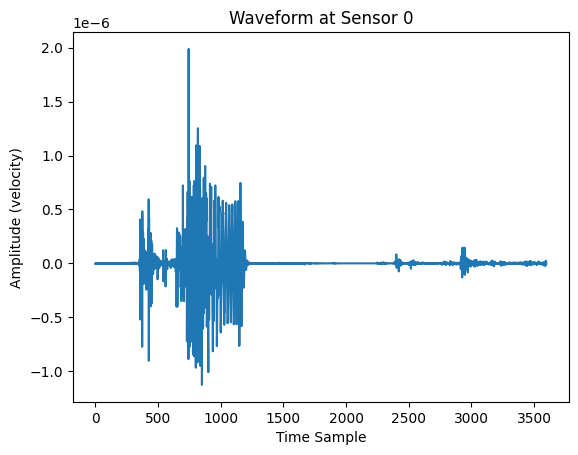

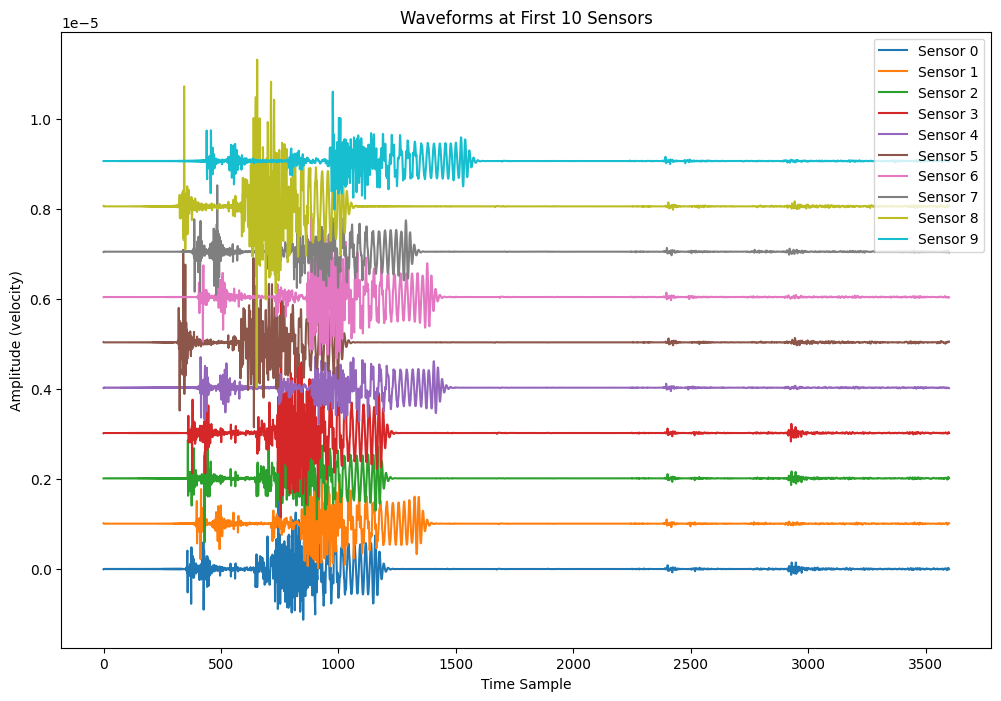

In [ ]:
# now re-read the data and replot it
with h5py.File('/Users/marinedenolle/wavefield_data.h5', 'r') as hf:
    X_loaded = hf['instaseis'][:]
print(X_loaded.shape)

# extract the wavefield data
wavefield_loaded = X_loaded[:N_SENSORS, :]
print(wavefield_loaded.shape)
import matplotlib.pyplot as plt
plt.plot(wavefield_loaded[0, :])
plt.title('Waveform at Sensor 0')
plt.xlabel('Time Sample')
plt.ylabel(f'Amplitude ({UNITS})')
plt.show()

# now plot the first 10 sensors in a single figure
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.plot(wavefield_loaded[i, :] + i*global_max*2, label=f'Sensor {i}')  # Offset for visibility
plt.title('Waveforms at First 10 Sensors')
plt.xlabel('Time Sample')
plt.ylabel(f'Amplitude ({UNITS})')
plt.legend()
plt.show()

In [ ]:
# # plot again all of the data as snapshots on a sphere and store as a gif
# print("Re-creating GIF animation from loaded data...")
# images = []
# for frame_idx, (idx, t) in enumerate(zip(animation_indices, animation_times)):
#     print(f"Creating snapshot {frame_idx+1}/{n_snapshots} at time {t:.1f}s...")
    
#     # Create figure for single snapshot
#     fig = plt.figure(figsize=(12, 10))
#     ax = fig.add_subplot(111, projection='3d')
    
#     # Create data for this snapshot
#     values = []
#     coords = []
    
#     for sta_idx in range(N_SENSORS):
#         values.append(wavefield_loaded[sta_idx, idx])
#         # Get corresponding lat/lon from sensor grid
#         lat, lon = sensor_grid[sta_idx]
#         # Convert to 3D coordinates
#         lat_rad = np.radians(lat)
#         lon_rad = np.radians(lon)
#         x = np.cos(lat_rad) * np.cos(lon_rad)
#         y = np.cos(lat_rad) * np.sin(lon_rad)
#         z = np.sin(lat_rad)
#         coords.append((x, y, z))
    
#     # Convert to numpy arrays
#     values = np.array(values)
#     coords = np.array(coords)

    
#     # Interpolate values onto the high-resolution grid
#     interpolated_values = griddata(
#         coords, values, interp_points, 
#         method='nearest', fill_value=0.0
#     )

#     # Reshape back to grid form
#     values_grid = interpolated_values.reshape(theta_grid.shape)
#     # # Plot the interpolated surface
#     surf = ax.plot_surface(
#         x_grid, y_grid, z_grid, 
#         facecolors=plt.cm.seismic((values_grid - (-global_max)) / (2 * global_max)),
#         alpha=0.9,
#         linewidth=0,
#         antialiased=True,
#         shade=False
#     )
    
#     # Add the original sensor points as small dots
#     ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
#               c=values, cmap='seismic', s=28, 
#               vmin=-global_max, vmax=global_max,
#               alpha=0.9, edgecolors='black', linewidth=0.1)
    
#     # Add earthquake source
#     source_lat_rad = np.radians(source['lat'])
#     source_lon_rad = np.radians(source['lon'])
#     source_x = np.cos(source_lat_rad) * np.cos(source_lon_rad)
#     source_y = np.cos(source_lat_rad) * np.sin(source_lon

Make sure it is well stored and show how to plot it

(6150, 3600)
{'wavefield_data_dimension_2D': [2048, 3600], 'source_info_2D': ['source_lat', 'source_lon', 'source_depth', 'strike', 'dip', 'rake'], 'sensor_info_2D': ['sensor_lat', 'sensor_lon'], 'units': 'velocity', 'component_order': ['Z'], 'regime': {'name': 'R10', 'model': 'iasp91_2s', 'atten': True}, 'N_SENSORS': 2048, 'dt (s)': 1.0}
3600


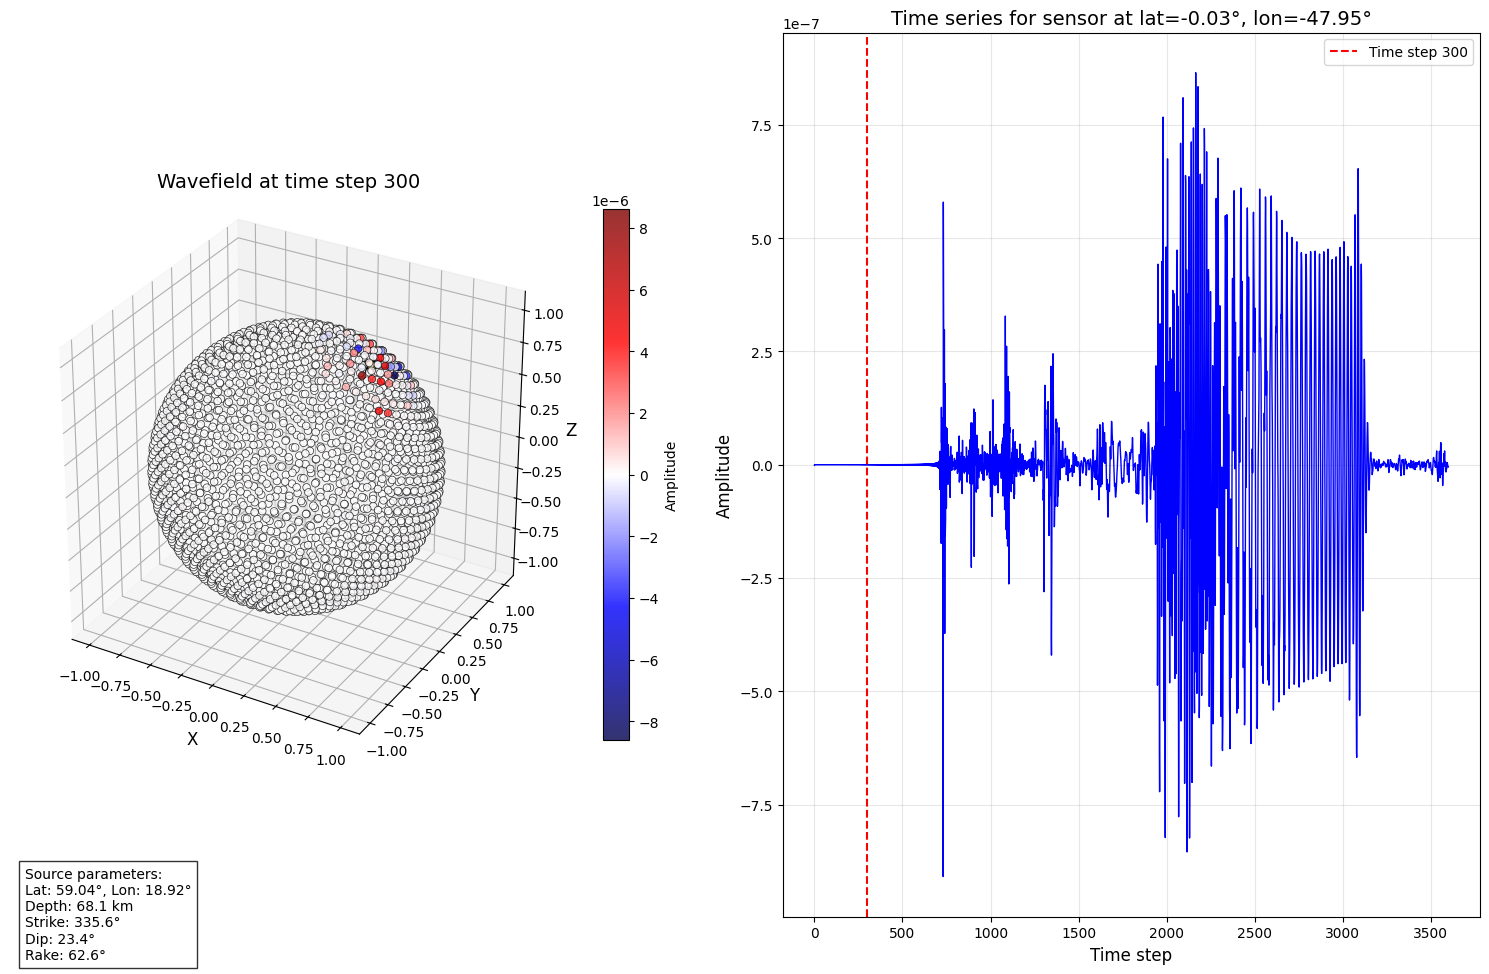

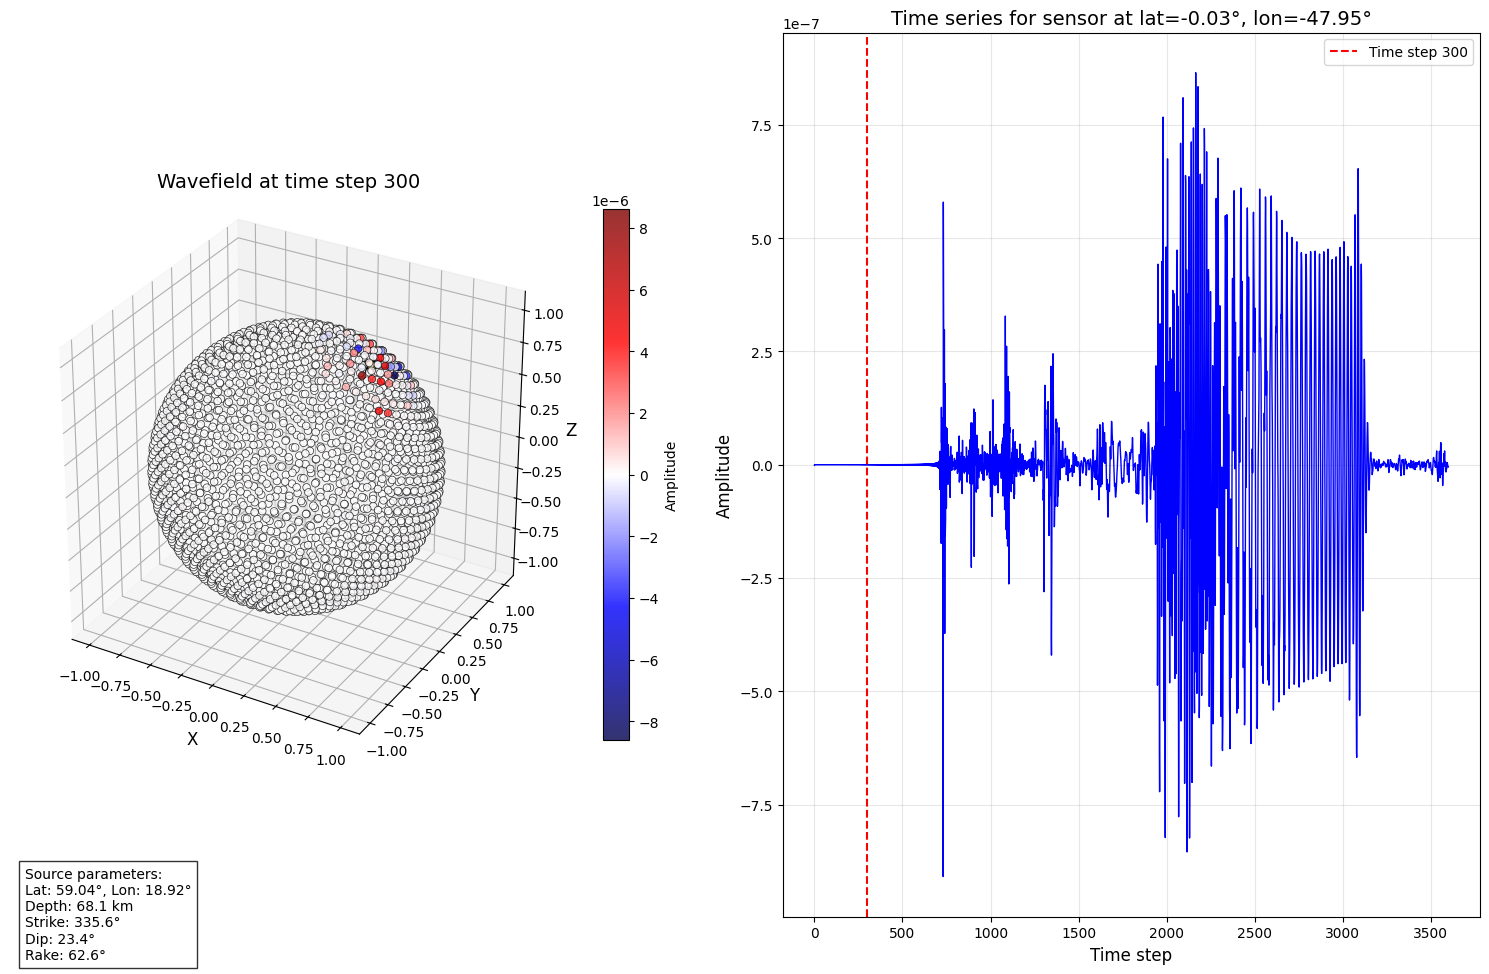

In [ ]:
import h5py
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

# Load data from H5 file
def load_wavefield_data(file_path='/Users/marinedenolle/wavefield_data.h5'):
    """Load data from the HDF5 file and return as a dictionary"""
  # load raw numpy array from h5 file
    with h5py.File(file_path, 'r') as hf:
        X_loaded = hf['instaseis'][:]
    print(X_loaded.shape)

    # load keys from json file (strip file name and add json extension)
    ff = file_path.split('.')[0] + '_keys.json'
    import json
    with open(ff, 'r') as f:
        X_keys = json.load(f)
    print(X_keys)

    return X_loaded, X_keys

# Create visualization of wavefield at a specific time
def visualize_wavefield_at_time(X_loaded, X_keys, time_idx=20000):
    """Create a 3D visualization of the wavefield at a specific time"""


    # "wavefield_data_dimension_2D": [N_SENSORS, wavefield_array.shape[1]],  # rows, columns
    # "source_info_2D": ['source_lat', 'source_lon', 'source_depth', 'strike', 'dip', 'rake'],
    # "sensor_info_2D": ['sensor_lat', 'sensor_lon'],

    wavefield = X_loaded[:X_keys['N_SENSORS'], :]
    source_info = X_loaded[X_keys['N_SENSORS']:X_keys['N_SENSORS']+6, 0].reshape(1, 6)
    sensor_info = X_loaded[X_keys['N_SENSORS']+6:, 0].reshape(X_keys['N_SENSORS'], 2)

    # Extract lat/lon for each sensor (using the first time point since they don't change)
    lats = sensor_info[:, 0]
    lons = sensor_info[:, 1]
    
    # Extract source information (using the first time point)
    source_lat = source_info[0,  0]
    source_lon = source_info[0, 1]
    source_depth = source_info[0, 2]
    source_strike = source_info[0, 3]
    source_dip = source_info[0, 4]
    source_rake = source_info[0, 5]
    
    # Create a figure
    fig = plt.figure(figsize=(15, 10))
    
    # Add a 3D plot for the wavefield
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Convert lat/lon to 3D coordinates
    x, y, z = [], [], []
    for lat, lon in zip(lats, lons):
        lat_rad = np.radians(lat)
        lon_rad = np.radians(lon)
        x.append(np.cos(lat_rad) * np.cos(lon_rad))
        y.append(np.cos(lat_rad) * np.sin(lon_rad))
        z.append(np.sin(lat_rad))
    
    # Get wavefield values at the specified time
    values = wavefield[:, time_idx]
    
    # Find global min/max for colormap
    global_max = np.max(np.abs(values))
    
    # Plot sensors colored by wavefield amplitude
    scatter = ax1.scatter(x, y, z, c=values, cmap='seismic', 
                         s=30, vmin=-global_max, vmax=global_max, 
                         alpha=0.8, edgecolors='black', linewidth=0.5)
    
    # Draw a wireframe sphere for reference
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    sphere_x = np.cos(u) * np.sin(v)
    sphere_y = np.sin(u) * np.sin(v)
    sphere_z = np.cos(v)
    ax1.plot_wireframe(sphere_x, sphere_y, sphere_z, color='gray', alpha=0.2)
    
    # Add earthquake source
    source_lat_rad = np.radians(source_lat)
    source_lon_rad = np.radians(source_lon)
    source_x = np.cos(source_lat_rad) * np.cos(source_lon_rad)
    source_y = np.cos(source_lat_rad) * np.sin(source_lon_rad)
    source_z = np.sin(source_lat_rad)
    ax1.scatter([source_x], [source_y], [source_z], 
               color='yellow', s=200, marker='*', 
               edgecolor='black', linewidth=1.5,
               label='Earthquake')
    
    # Set title and labels
    ax1.set_title(f'Wavefield at time step {time_idx}', fontsize=14)
    ax1.set_xlabel('X', fontsize=12)
    ax1.set_ylabel('Y', fontsize=12)
    ax1.set_zlabel('Z', fontsize=12)
    
    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax1, shrink=0.6)
    cbar.set_label('Amplitude')
    
    # Try to set equal aspect ratio
    try:
        ax1.set_box_aspect([1,1,1])
    except AttributeError:
        ax1.set_aspect('equal')
    
    # Add a plot for a time series at a specific sensor
    ax2 = fig.add_subplot(122)
    
    # Select a sensor (pick one near the middle of the array)
    sensor_idx = len(wavefield) // 2
    
    # Plot time series
    ax2.plot(wavefield[sensor_idx], 'b-', linewidth=1)
    ax2.axvline(x=time_idx, color='r', linestyle='--', label=f'Time step {time_idx}')
    ax2.set_title(f'Time series for sensor at lat={lats[sensor_idx]:.2f}°, lon={lons[sensor_idx]:.2f}°', fontsize=14)
    ax2.set_xlabel('Time step', fontsize=12)
    ax2.set_ylabel('Amplitude', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add source information as text
    source_info_text = (f"Source parameters:\n"
                        f"Lat: {source_lat:.2f}°, Lon: {source_lon:.2f}°\n"
                        f"Depth: {source_depth/1000:.1f} km\n"
                        f"Strike: {source_strike:.1f}°\n"
                        f"Dip: {source_dip:.1f}°\n"
                        f"Rake: {source_rake:.1f}°")
    
    plt.figtext(0.02, 0.02, source_info_text, fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig


# Load data
X_loaded,X_keys = load_wavefield_data()

# Visualize wavefield at a specific time
# Choose a time that's about halfway through the data
time_idx = X_loaded.shape[1] 
print(time_idx)
visualize_wavefield_at_time(X_loaded, X_keys,300)

# Many more sims

Now create several simulations for a single regime and store that for the in-domain data

In [ ]:
# Generate sensor locations using fibonacci sphere
sensor_locations = fibonacci_sphere(N_SENSORS)
lats, lons = zip(*sensor_locations)
print(f"Generated {N_SENSORS} sensor locations.")
bulk = [{"latitude": lat, "longitude": lon, "stationcode": f"S{idx:03d}"}
    for idx, (lat, lon) in enumerate(sensor_locations)]
print(f"Prepared bulk request for {len(bulk)} sensors.")

Generated 2048 sensor locations.
Prepared bulk request for 2048 sensors.


In [ ]:
# select the first regime
selected_regime = REGIMES[-1]

In [ ]:
# randomly generate N sources for thurst/normal
N_SOURCES = 10
sources = [random_dc(0.3) for _ in range(N_SOURCES)]

In [ ]:
# loop over sources and get waveforms
for i, source in enumerate(tqdm(sources, desc="Processing sources")):
    st = syn.get_waveforms_bulk(
        model=selected_regime["model"],
        bulk=bulk,
        sourcelatitude=source["lat"],
        sourcelongitude=source["lon"],
        sourcedepthinmeters=float(source["depth"]),
        sourcedoublecouple=[source["strike"], source["dip"], source["rake"], float(source["m0"])],
        origintime=ot,
        starttime=WINDOW_START,
        endtime=WINDOW_END,
        components=COMPONENTS,
        units=UNITS,
        format="miniseed"
    )
    print(f"Source {i+1}/{N_SOURCES}: Retrieved {len(st)} traces")
    # Resample all traces to DT_OPTIONAL
    if DT_OPTIONAL is not None:
        for tr in st:
            tr.resample(sampling_rate=1.0/DT_OPTIONAL)

    # generate wavefield_2D array for this source
    wavefield_data = {}
    for tr in st:
        station_code = tr.stats.station
        wavefield_data[station_code] = tr.data
    wavefield_array = np.array([wavefield_data[sta] for sta in wavefield_data])
    print(f"Wavefield array shape: {wavefield_array.shape}")

    # append wavefield data on the 
    # transform the dictionary wavefield_data into a 2D numpy array
    wavefield_data = {}
    for tr in st:
        station_code = tr.stats.station
        wavefield_data[station_code] = tr.data

    wavefield_array = np.array([wavefield_data[sta] for sta in wavefield_data])
    print(wavefield_array.shape)

    # make a 2D array with each row the latitude and longitude of the sensors and the column their repeated values to be of the same length as wavefield_data
    sensor_info = np.array([[lat, lon] for (lat, lon) in zip(lats, lons)])
    sensor_info_2D = np.repeat(sensor_info[:, :].flatten().transpose()[:, np.newaxis], wavefield_array.shape[1], axis=1)
        
    # make an array of earthquake source latitude, longitude, depth, strike, dip, rake and make their columns repeated to be the same length as wavefield_data
    source_info = np.array([[source['lat'], source['lon'], source['depth'], source['strike'], source['dip'], source['rake']]])
    source_info_2D = np.repeat(source_info.transpose(), wavefield_array.shape[1], axis=1)


    # concatenate vertically all data into a single numpy array
    print(wavefield_array.shape, source_info_2D.shape, sensor_info_2D.shape)
    X = np.vstack((wavefield_array, source_info_2D, sensor_info_2D))
    print(X.shape)

    # create a dictionary that explains what the X array contains with the different array dimensions or definitions

    data_keys = {
        "wavefield_data_dimension_2D": [N_SENSORS, wavefield_array.shape[1]],  # rows, columns
        "source_info_2D": ['source_lat', 'source_lon', 'source_depth', 'strike', 'dip', 'rake'],
        "sensor_info_2D": ['sensor_lat', 'sensor_lon'],
        "units": UNITS,
        "component_order": component_order,
        "regime": selected_regime,
        "N_SENSORS": N_SENSORS,
        "dt (s)": DT_OPTIONAL
    }


    # store data_keys in a json file
    import json
    with open('/Users/marinedenolle/Dropbox/CTF_seismo/instaseis/wavefield_data_keys{}.json'.format(i), 'w') as f:
        json.dump(data_keys, f, indent=4)


    with h5py.File('/Users/marinedenolle/Dropbox/CTF_seismo/instaseis/wavefield_data{}.h5'.format(i), 'w') as hf:
            hf.create_dataset('instaseis', data=X) 
    # print size of the h5 file in GB
    import os
    file_size = os.path.getsize('/Users/marinedenolle/Dropbox/CTF_seismo/instaseis/wavefield_data{}.h5'.format(i)) / (1024 * 1024 * 1024)  # in GB
    print(f"H5 file size: {file_size:.2f} GB")


Processing sources:   0%|          | 0/10 [00:00<?, ?it/s]

Source 1/10: Retrieved 2048 traces


Processing sources:  10%|█         | 1/10 [08:09<1:13:23, 489.31s/it]

Wavefield array shape: (2048, 3600)
(2048, 3600)
(2048, 3600) (6, 3600) (4096, 3600)
(6150, 3600)
H5 file size: 0.16 GB
Source 2/10: Retrieved 2048 traces


Processing sources:  20%|██        | 2/10 [14:33<56:58, 427.31s/it]  

Wavefield array shape: (2048, 3600)
(2048, 3600)
(2048, 3600) (6, 3600) (4096, 3600)
(6150, 3600)
H5 file size: 0.16 GB
Source 3/10: Retrieved 2048 traces


Processing sources:  30%|███       | 3/10 [21:18<48:39, 417.08s/it]

Wavefield array shape: (2048, 3600)
(2048, 3600)
(2048, 3600) (6, 3600) (4096, 3600)
(6150, 3600)
H5 file size: 0.16 GB
Source 4/10: Retrieved 2048 traces


Processing sources:  40%|████      | 4/10 [27:36<40:11, 401.95s/it]

Wavefield array shape: (2048, 3600)
(2048, 3600)
(2048, 3600) (6, 3600) (4096, 3600)
(6150, 3600)
H5 file size: 0.16 GB
Source 5/10: Retrieved 2048 traces


Processing sources:  50%|█████     | 5/10 [34:24<33:40, 404.00s/it]

Wavefield array shape: (2048, 3600)
(2048, 3600)
(2048, 3600) (6, 3600) (4096, 3600)
(6150, 3600)
H5 file size: 0.16 GB
Source 6/10: Retrieved 2048 traces


Processing sources:  60%|██████    | 6/10 [41:16<27:07, 406.76s/it]

Wavefield array shape: (2048, 3600)
(2048, 3600)
(2048, 3600) (6, 3600) (4096, 3600)
(6150, 3600)
H5 file size: 0.16 GB
Source 7/10: Retrieved 2048 traces


Processing sources:  70%|███████   | 7/10 [47:29<19:47, 395.67s/it]

Wavefield array shape: (2048, 3600)
(2048, 3600)
(2048, 3600) (6, 3600) (4096, 3600)
(6150, 3600)
H5 file size: 0.16 GB


Processing sources:  70%|███████   | 7/10 [54:07<23:11, 463.97s/it]


ConnectionError: HTTPConnectionPool(host='service.iris.edu', port=80): Read timed out.

In [ ]:
# generate CTF for out of domain data with shallow strike slip earthquakes, same as above for random_dc(0.7)

# randomly generate N sources for strike slip
N_SOURCES = 3
sources = [random_dc(0.7) for _ in range(N_SOURCES)]

# loop over sources and get waveforms
for i, source in enumerate(tqdm(sources, desc="Processing sources")):
    st = syn.get_waveforms_bulk(
        model=selected_regime["model"],
        bulk=bulk,
        sourcelatitude=source["lat"],
        sourcelongitude=source["lon"],
        sourcedepthinmeters=float(source["depth"]),
        sourcedoublecouple=[source["strike"], source["dip"], source["rake"], float(source["m0"])],
        origintime=ot,
        starttime=WINDOW_START,
        endtime=WINDOW_END,
        components=COMPONENTS,
        units=UNITS,
        format="miniseed"
    )
    print(f"Source {i+1}/{N_SOURCES}: Retrieved {len(st)} traces")
    # Resample all traces to DT_OPTIONAL
    if DT_OPTIONAL is not None:
        for tr in st:
            tr.resample(sampling_rate=1.0/DT_OPTIONAL)

    # generate wavefield_2D array for this source
    wavefield_data = {}
    for tr in st:
        station_code = tr.stats.station
        wavefield_data[station_code] = tr.data
    wavefield_array = np.array([wavefield_data[sta] for sta in wavefield_data])
    print(f"Wavefield array shape: {wavefield_array.shape}")

    # append wavefield data on the 
    # transform the dictionary wavefield_data into a 2D numpy array
    wavefield_data = {}
    for tr in st:
        station_code = tr.stats.station
        wavefield_data[station_code] = tr.data

    wavefield_array = np.array([wavefield_data[sta] for sta in wavefield_data])
    print(wavefield_array.shape)

    # make a 2D array with each row the latitude and longitude of the sensors and the column their repeated values to be of the same length as wavefield_data
    sensor_info = np.array([[lat, lon] for (lat, lon) in zip(lats, lons)])
    sensor_info_2D = np.repeat(sensor_info[:, :].flatten().transpose()[:, np.newaxis], wavefield_array.shape[1], axis=1)
        
    # make an array of earthquake source latitude, longitude, depth, strike, dip, rake and make their columns repeated to be the same length as wavefield_data
    source_info = np.array([[source['lat'], source['lon'], source['depth'], source['strike'], source['dip'], source['rake']]])
    source_info_2D = np.repeat(source_info.transpose(), wavefield_array.shape[1], axis=1)


    # concatenate vertically all data into a single numpy array
    print(wavefield_array.shape, source_info_2D.shape, sensor_info_2D.shape)
    X = np.vstack((wavefield_array, source_info_2D, sensor_info_2D))
    print(X.shape)

    # create a dictionary that explains what the X array contains with the different array dimensions or definitions

    data_keys = {
        "wavefield_data_dimension_2D": [N_SENSORS, wavefield_array.shape[1]],  # rows, columns
        "source_info_2D": ['source_lat', 'source_lon', 'source_depth', 'strike', 'dip', 'rake'],
        "sensor_info_2D": ['sensor_lat', 'sensor_lon'],
        "units": UNITS,
        "component_order": component_order,
        "regime": selected_regime,
        "N_SENSORS": N_SENSORS,
        "dt (s)": DT_OPTIONAL
    }


    # store data_keys in a json file
    import json
    with open('/Users/marinedenolle/Dropbox/Instaseis/wavefield_outofdomain_data_keys{}.json'.format(i), 'w') as f:
        json.dump(data_keys, f, indent=4)


    with h5py.File('/Users/marinedenolle/Dropbox/Instaseis/wavefield_outofdomain_data{}.h5'.format(i), 'w') as hf:
            hf.create_dataset('instaseis', data=X) 
    # print size of the h5 file in GB
    import os
    file_size = os.path.getsize('/Users/marinedenolle/Dropbox/Instaseis/wavefield_outofdomain_data{}.h5'.format(i)) / (1024 * 1024 * 1024)  # in GB
    print(f"H5 file size: {file_size:.2f} GB")


Processing sources:   0%|          | 0/3 [00:00<?, ?it/s]

# Download Real Seismic Data from M≥7.0 Earthquakes (2023)

This section downloads real seismic waveform data from global seismic networks II and IU for all earthquakes with magnitude ≥7.0 that occurred in 2023. We'll query the earthquake catalog, download 3-component long-period data (LHZ, LHN, LHE), and visualize the results.

In [ ]:
# Initialize FDSN client and query earthquake catalog
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Initialize IRIS FDSN client (best for global networks II and IU)
client = Client("IRIS")

# Define query parameters for 2023 M≥7.0 earthquakes
starttime = UTCDateTime("2023-01-01")
endtime = UTCDateTime("2023-12-31T23:59:59")
min_magnitude = 7.0

print(f"Querying earthquake catalog for M≥{min_magnitude} events in 2023...")
catalog = client.get_events(
    starttime=starttime,
    endtime=endtime,
    minmagnitude=min_magnitude,
    orderby="time"
)

print(f"\nFound {len(catalog)} earthquakes with M≥{min_magnitude} in 2023:\n")
print("="*80)

# Display earthquake summary
for i, event in enumerate(catalog, 1):
    origin = event.preferred_origin() or event.origins[0]
    magnitude = event.preferred_magnitude() or event.magnitudes[0]
    
    print(f"{i:2d}. {origin.time} | Lat: {origin.latitude:7.2f}° Lon: {origin.longitude:7.2f}° | "
          f"Depth: {origin.depth/1000:5.1f} km | M {magnitude.mag:.1f}")

print("="*80)

In [ ]:
# Define data download parameters
NETWORKS = "II,IU"  # Global seismic networks
CHANNELS = "LH?"     # Long-period channels: LHZ (vertical), LHN (north), LHE (east)
TIME_BEFORE = 60     # seconds before origin time
TIME_AFTER = 3600    # 1 hour after origin time
OUTPUT_DIR = "real_earthquake_data"

# Pre-processing parameters
REMOVE_RESPONSE = True  # Remove instrument response to get physical units
FILTER_TYPE = "bandpass"
FREQMIN = 0.01  # 100 second period
FREQMAX = 0.1   # 10 second period
UNITS = "DISP"  # Displacement (can be "DISP", "VEL", "ACC")

# Create output directory
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Download parameters:")
print(f"  Networks: {NETWORKS}")
print(f"  Channels: {CHANNELS}")
print(f"  Time window: {TIME_BEFORE}s before to {TIME_AFTER}s after origin")
print(f"  Filter: {FILTER_TYPE} [{FREQMIN}-{FREQMAX}] Hz")
print(f"  Output directory: {OUTPUT_DIR}/")
print(f"  Remove response: {REMOVE_RESPONSE} (output in {UNITS})")

In [ ]:
# Download waveforms for each earthquake
from obspy.geodetics import gps2dist_azimuth
import warnings

# Dictionary to store all downloaded data
earthquake_data = {}
download_summary = []

print(f"\nDownloading waveforms for {len(catalog)} earthquakes...")
print("="*80)

for event_idx, event in enumerate(catalog, 1):
    origin = event.preferred_origin() or event.origins[0]
    magnitude = event.preferred_magnitude() or event.magnitudes[0]
    event_id = str(event.resource_id).split('/')[-1]
    
    print(f"\n[{event_idx}/{len(catalog)}] Event ID: {event_id}")
    print(f"  Time: {origin.time}")
    print(f"  Location: {origin.latitude:.2f}°, {origin.longitude:.2f}°, {origin.depth/1000:.1f} km")
    print(f"  Magnitude: {magnitude.mag:.1f}")
    
    # Define time window
    t1 = origin.time - TIME_BEFORE
    t2 = origin.time + TIME_AFTER
    
    try:
        # Download waveforms
        print(f"  Downloading from networks {NETWORKS}...")
        st = client.get_waveforms(
            network=NETWORKS,
            station="*",
            location="*",
            channel=CHANNELS,
            starttime=t1,
            endtime=t2,
            attach_response=True
        )
        
        print(f"  Downloaded {len(st)} traces")
        
        # Pre-process waveforms
        print(f"  Processing: detrend, taper, filter, remove response...")
        st.detrend("linear")
        st.taper(max_percentage=0.05)
        
        if REMOVE_RESPONSE:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                st.remove_response(output=UNITS, pre_filt=(0.005, 0.01, 0.2, 0.4))
        
        st.filter(FILTER_TYPE, freqmin=FREQMIN, freqmax=FREQMAX)
        
        # Organize by station
        stations_dict = {}
        for tr in st:
            station_id = f"{tr.stats.network}.{tr.stats.station}"
            if station_id not in stations_dict:
                stations_dict[station_id] = []
            stations_dict[station_id].append(tr)
        
        print(f"  Organized into {len(stations_dict)} stations")
        
        # Store data with metadata
        earthquake_data[event_id] = {
            'stream': st,
            'origin_time': origin.time,
            'latitude': origin.latitude,
            'longitude': origin.longitude,
            'depth_km': origin.depth / 1000.0,
            'magnitude': magnitude.mag,
            'n_traces': len(st),
            'n_stations': len(stations_dict)
        }
        
        download_summary.append({
            'event_id': event_id,
            'time': str(origin.time),
            'lat': origin.latitude,
            'lon': origin.longitude,
            'depth_km': origin.depth / 1000.0,
            'magnitude': magnitude.mag,
            'n_traces': len(st),
            'n_stations': len(stations_dict)
        })
        
        print(f"  ✓ Success!")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        download_summary.append({
            'event_id': event_id,
            'time': str(origin.time),
            'lat': origin.latitude,
            'lon': origin.longitude,
            'depth_km': origin.depth / 1000.0,
            'magnitude': magnitude.mag,
            'n_traces': 0,
            'n_stations': 0,
            'error': str(e)
        })

print("\n" + "="*80)
print(f"Download complete! Successfully retrieved data for {len(earthquake_data)}/{len(catalog)} earthquakes")
print("="*80)

In [ ]:
# Save data as NPZ arrays
import pandas as pd

print("Saving earthquake data to NPZ files...")

for event_id, data in earthquake_data.items():
    st = data['stream']
    
    # Extract waveform data organized by station and channel
    waveforms_list = []
    station_info_list = []
    
    for tr in st:
        waveforms_list.append(tr.data)
        station_info_list.append({
            'network': tr.stats.network,
            'station': tr.stats.station,
            'location': tr.stats.location,
            'channel': tr.stats.channel,
            'latitude': tr.stats.coordinates.latitude if hasattr(tr.stats, 'coordinates') else None,
            'longitude': tr.stats.coordinates.longitude if hasattr(tr.stats, 'coordinates') else None,
            'elevation': tr.stats.coordinates.elevation if hasattr(tr.stats, 'coordinates') else None,
            'sampling_rate': tr.stats.sampling_rate,
            'npts': tr.stats.npts,
            'starttime': str(tr.stats.starttime)
        })
    
    # Create structured arrays
    max_length = max([len(w) for w in waveforms_list]) if waveforms_list else 0
    
    # Pad waveforms to same length
    waveforms_padded = np.array([
        np.pad(w, (0, max_length - len(w)), mode='constant', constant_values=0) 
        for w in waveforms_list
    ])
    
    # Source information
    source_info = np.array([
        data['latitude'],
        data['longitude'],
        data['depth_km'],
        data['magnitude'],
        data['origin_time'].timestamp
    ])
    
    # Save as NPZ
    npz_file = os.path.join(OUTPUT_DIR, f"earthquake_{event_id}.npz")
    np.savez_compressed(
        npz_file,
        waveforms=waveforms_padded,
        source_info=source_info,
        source_keys=['latitude', 'longitude', 'depth_km', 'magnitude', 'origin_timestamp'],
        metadata=station_info_list
    )
    
    file_size_mb = os.path.getsize(npz_file) / (1024 * 1024)
    print(f"  {event_id}: {file_size_mb:.2f} MB ({data['n_traces']} traces, {data['n_stations']} stations)")

# Save summary as CSV
summary_df = pd.DataFrame(download_summary)
summary_file = os.path.join(OUTPUT_DIR, "download_summary.csv")
summary_df.to_csv(summary_file, index=False)

print(f"\n✓ Saved {len(earthquake_data)} NPZ files to {OUTPUT_DIR}/")
print(f"✓ Saved download summary to {summary_file}")

# Display summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Total earthquakes queried: {len(catalog)}")
print(f"Successful downloads: {len(earthquake_data)}")
print(f"Total traces downloaded: {summary_df['n_traces'].sum()}")
print(f"Total stations: {summary_df['n_stations'].sum()}")
print(f"Average traces per earthquake: {summary_df['n_traces'].mean():.1f}")
print("="*80)

## Visualize Real Seismic Data

Now let's visualize the downloaded waveforms using multiple approaches:
1. **Traditional seismograms** (matplotlib) - Static record sections
2. **Interactive waveform explorer** (longboard) - Pan, zoom, and inspect waveforms
3. **Geographic map view** (cartopy) - Station locations and earthquake epicenters

In [ ]:
# Traditional seismogram visualization with matplotlib
from obspy.geodetics import gps2dist_azimuth
from obspy.taup import TauPyModel

# Select an earthquake to visualize (change index to view different events)
if len(earthquake_data) > 0:
    event_id = list(earthquake_data.keys())[0]  # First earthquake
    data = earthquake_data[event_id]
    st = data['stream'].copy()
    
    print(f"Visualizing earthquake: {event_id}")
    print(f"  Time: {data['origin_time']}")
    print(f"  Location: {data['latitude']:.2f}°, {data['longitude']:.2f}°")
    print(f"  Magnitude: {data['magnitude']:.1f}")
    print(f"  Traces: {len(st)}")
    
    # Calculate distances for each trace
    distances = []
    for tr in st:
        if hasattr(tr.stats, 'coordinates'):
            dist_m, az, baz = gps2dist_azimuth(
                data['latitude'], data['longitude'],
                tr.stats.coordinates.latitude, tr.stats.coordinates.longitude
            )
            distances.append(dist_m / 1000.0)  # Convert to km
        else:
            distances.append(0)
    
    # Sort by distance
    sorted_indices = np.argsort(distances)
    
    # Create record section plot
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot each trace
    scale_factor = np.max([np.max(np.abs(tr.data)) for tr in st]) * 1.5
    colors = {'Z': 'black', 'N': 'red', 'E': 'blue'}
    
    plotted_distances = []
    for idx in sorted_indices[:50]:  # Plot first 50 traces
        tr = st[idx]
        dist = distances[idx]
        
        # Normalize and offset by distance
        normalized = tr.data / scale_factor
        time_axis = np.arange(len(normalized)) * tr.stats.delta
        
        # Get color based on channel
        channel = tr.stats.channel[-1]  # Last character (Z, N, or E)
        color = colors.get(channel, 'gray')
        
        ax.plot(time_axis, normalized + dist, color=color, linewidth=0.5, alpha=0.8)
        plotted_distances.append(dist)
    
    ax.set_xlabel('Time after origin (s)', fontsize=12)
    ax.set_ylabel('Distance (km)', fontsize=12)
    ax.set_title(f'Record Section: M{data["magnitude"]:.1f} Earthquake\\n'
                 f'{data["origin_time"]} | {data["latitude"]:.2f}°, {data["longitude"]:.2f}°',
                 fontsize=14, fontweight='bold')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=2, label='Vertical (Z)'),
        Line2D([0], [0], color='red', linewidth=2, label='North (N)'),
        Line2D([0], [0], color='blue', linewidth=2, label='East (E)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Individual station 3-component view
    # Find a station with all 3 components
    station_groups = {}
    for tr in st:
        sta_id = f"{tr.stats.network}.{tr.stats.station}"
        if sta_id not in station_groups:
            station_groups[sta_id] = []
        station_groups[sta_id].append(tr)
    
    # Find first station with 3 components
    for sta_id, traces in station_groups.items():
        if len(traces) >= 3:
            fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
            
            for i, tr in enumerate(sorted(traces, key=lambda x: x.stats.channel)[:3]):
                time_axis = np.arange(len(tr.data)) * tr.stats.delta
                axes[i].plot(time_axis, tr.data, 'k-', linewidth=0.8)
                axes[i].set_ylabel(f'{tr.stats.channel}\\nAmplitude', fontsize=10)
                axes[i].grid(True, alpha=0.3)
                axes[i].text(0.02, 0.95, f'{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}',
                           transform=axes[i].transAxes, fontsize=10,
                           verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            axes[-1].set_xlabel('Time after origin (s)', fontsize=12)
            fig.suptitle(f'3-Component Seismogram: {sta_id}\\n'
                        f'M{data["magnitude"]:.1f} Earthquake at {data["origin_time"]}',
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            break
    
else:
    print("No earthquake data available to visualize")

In [ ]:
# Interactive waveform explorer using Longboard
try:
    from longboard import WaveformPlotter
    
    if len(earthquake_data) > 0:
        # Select an earthquake (you can change the index to view different events)
        event_id = list(earthquake_data.keys())[0]
        data = earthquake_data[event_id]
        st_interactive = data['stream'].copy()
        
        print(f"Creating interactive plot for earthquake: {event_id}")
        print(f"  M{data['magnitude']:.1f} at {data['origin_time']}")
        print(f"  {len(st_interactive)} traces")
        print("\\nInteractive features:")
        print("  - Click and drag to pan")
        print("  - Scroll to zoom")
        print("  - Hover over traces to see details")
        print("  - Use toolbar buttons for additional controls")
        
        # Trim stream to reasonable size for interactive viewing (max 30 traces)
        if len(st_interactive) > 30:
            print(f"  (Showing first 30 of {len(st_interactive)} traces for performance)")
            st_interactive = st_interactive[:30]
        
        # Create interactive plot
        plotter = WaveformPlotter(st_interactive)
        plotter.show()
    else:
        print("No earthquake data available to visualize")
        
except ImportError as e:
    print("Longboard is not installed or could not be imported.")
    print("To install: pip install longboard")
    print(f"Error: {e}")
    print("\\nYou can still use the matplotlib visualizations above.")

In [ ]:
# Geographic map visualization using Cartopy
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    
    if len(earthquake_data) > 0:
        # Create figure with map projection
        fig = plt.figure(figsize=(16, 10))
        
        # Plot 1: Global view with all earthquakes and stations
        ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson())
        ax1.set_global()
        ax1.add_feature(cfeature.LAND, facecolor='lightgray')
        ax1.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax1.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
        ax1.gridlines(draw_labels=False, alpha=0.3)
        
        # Plot all earthquakes
        eq_lats = [data['latitude'] for data in earthquake_data.values()]
        eq_lons = [data['longitude'] for data in earthquake_data.values()]
        eq_mags = [data['magnitude'] for data in earthquake_data.values()]
        
        # Size earthquakes by magnitude
        eq_sizes = [50 * (mag - 6.5)**2 for mag in eq_mags]
        
        ax1.scatter(eq_lons, eq_lats, s=eq_sizes, c='red', marker='*',
                   edgecolors='darkred', linewidth=1, alpha=0.8,
                   transform=ccrs.PlateCarree(), zorder=5,
                   label='Earthquakes (M≥7.0)')
        
        # Collect all unique station locations
        station_lats = []
        station_lons = []
        for data in earthquake_data.values():
            for tr in data['stream']:
                if hasattr(tr.stats, 'coordinates'):
                    station_lats.append(tr.stats.coordinates.latitude)
                    station_lons.append(tr.stats.coordinates.longitude)
        
        # Remove duplicates
        station_coords = list(set(zip(station_lats, station_lons)))
        if station_coords:
            sta_lats, sta_lons = zip(*station_coords)
            ax1.scatter(sta_lons, sta_lats, s=20, c='blue', marker='^',
                       edgecolors='darkblue', linewidth=0.5, alpha=0.6,
                       transform=ccrs.PlateCarree(), zorder=4,
                       label=f'Stations (n={len(station_coords)})')
        
        ax1.legend(loc='lower left', fontsize=10)
        ax1.set_title('Global Distribution: 2023 M≥7.0 Earthquakes\\nand II/IU Network Stations',
                     fontsize=12, fontweight='bold')
        
        # Plot 2: Zoom on first earthquake with station distribution
        event_id = list(earthquake_data.keys())[0]
        data = earthquake_data[event_id]
        
        ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Orthographic(
            central_longitude=data['longitude'],
            central_latitude=data['latitude']
        ))
        
        ax2.add_feature(cfeature.LAND, facecolor='lightgray')
        ax2.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax2.gridlines(alpha=0.3)
        
        # Plot earthquake
        ax2.scatter([data['longitude']], [data['latitude']], 
                   s=300, c='red', marker='*',
                   edgecolors='darkred', linewidth=2,
                   transform=ccrs.PlateCarree(), zorder=5,
                   label=f'M{data["magnitude"]:.1f} Earthquake')
        
        # Plot stations for this earthquake
        event_sta_lats = []
        event_sta_lons = []
        for tr in data['stream']:
            if hasattr(tr.stats, 'coordinates'):
                event_sta_lats.append(tr.stats.coordinates.latitude)
                event_sta_lons.append(tr.stats.coordinates.longitude)
        
        if event_sta_lats:
            ax2.scatter(event_sta_lons, event_sta_lats, s=30, c='blue', marker='^',
                       edgecolors='darkblue', linewidth=0.5, alpha=0.7,
                       transform=ccrs.PlateCarree(), zorder=4,
                       label=f'{len(event_sta_lats)} Recording Stations')
            
            # Draw distance circles (30°, 60°, 90°)
            from matplotlib.patches import Circle
            for dist_deg in [30, 60, 90]:
                circle = Circle((data['longitude'], data['latitude']), 
                              dist_deg, transform=ccrs.PlateCarree(),
                              fill=False, edgecolor='gray', linestyle='--',
                              linewidth=0.5, alpha=0.5)
                ax2.add_patch(circle)
        
        ax2.legend(loc='lower left', fontsize=10)
        ax2.set_title(f'Station Coverage for Event {event_id[:8]}...\\n'
                     f'{data["origin_time"].strftime("%Y-%m-%d %H:%M:%S")}',
                     fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\\nMap visualization complete!")
        print(f"  Total earthquakes: {len(earthquake_data)}")
        print(f"  Unique stations: {len(station_coords) if station_coords else 0}")
        
    else:
        print("No earthquake data available to visualize")
        
except ImportError as e:
    print("Cartopy is not installed or could not be imported.")
    print("To install: conda install -c conda-forge cartopy")
    print(f"Error: {e}")
    print("\\nYou can still use the matplotlib and longboard visualizations above.")

## Loading Saved Data

To load the saved earthquake data later, use the following code:

In [ ]:
# Example: Load saved earthquake data from NPZ file
import numpy as np
import glob

# List all saved NPZ files
npz_files = glob.glob(os.path.join(OUTPUT_DIR, "earthquake_*.npz"))
print(f"Found {len(npz_files)} saved earthquake files\\n")

if npz_files:
    # Load the first file as an example
    example_file = npz_files[0]
    print(f"Loading: {os.path.basename(example_file)}")
    
    # Load data
    loaded = np.load(example_file, allow_pickle=True)
    
    print(f"\\nContents:")
    print(f"  Keys: {list(loaded.keys())}")
    print(f"  Waveforms shape: {loaded['waveforms'].shape}")
    print(f"  Source info: {dict(zip(loaded['source_keys'], loaded['source_info']))}")
    print(f"  Number of traces: {len(loaded['metadata'])}")
    print(f"\\nFirst trace metadata:")
    print(f"  {loaded['metadata'][0]}")
    
    # Example: Plot a loaded waveform
    fig, ax = plt.subplots(figsize=(12, 4))
    trace_idx = 0
    waveform = loaded['waveforms'][trace_idx]
    metadata = loaded['metadata'][trace_idx]
    
    time_axis = np.arange(len(waveform)) / metadata['sampling_rate']
    ax.plot(time_axis, waveform, 'k-', linewidth=0.8)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    ax.set_title(f"Loaded Waveform: {metadata['network']}.{metadata['station']}.{metadata['channel']}",
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    loaded.close()
else:
    print("No NPZ files found. Run the download cells above first.")

## Summary and Next Steps

### What was added:
- **Earthquake catalog query**: Downloads metadata for all M≥7.0 earthquakes in 2023 from IRIS FDSN
- **Waveform download**: Retrieves LHZ, LHN, LHE channel data from global networks II and IU
- **Data processing**: Removes instrument response, filters, and organizes by station
- **Data storage**: Saves to NPZ format with waveforms, station info, and source parameters
- **Visualizations**: 
  - Traditional matplotlib record sections and 3-component plots
  - Interactive longboard explorer (optional, install separately with `pip install longboard`)
  - Geographic maps with Cartopy showing earthquake and station distributions

### To run this workflow:
1. Execute cells sequentially from the "Download Real Seismic Data" section
2. Data will be saved to the `real_earthquake_data/` directory
3. Downloads may take several minutes depending on network speed and data availability
4. Some earthquakes may have limited station coverage depending on network operations

### Optional: Install longboard for interactive plots
```bash
pip install longboard
```

### Notes:
- Networks II and IU are global seismic networks with excellent coverage
- LH channels are long-period (1 Hz sampling) suitable for teleseismic body and surface waves
- The 1-hour time window captures P, S, and early surface wave arrivals
- Data is filtered between 0.01-0.1 Hz (100-10 second periods)
- Some earthquakes may have no data if stations were offline or data not archived